Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Accuracy CatBoost optimizado: 0.4171
✅ F1 score (macro): 0.4038

📄 Classification report:
               precision    recall  f1-score   support

           0       0.44      0.55      0.49     51896
           1       0.32      0.23      0.27     51682
           2       0.32      0.27      0.29     51486
           3       0.53      0.61      0.57     52686

    accuracy                           0.42    207750
   macro avg       0.40      0.42      0.40    207750
weighted avg       0.40      0.42      0.40    207750



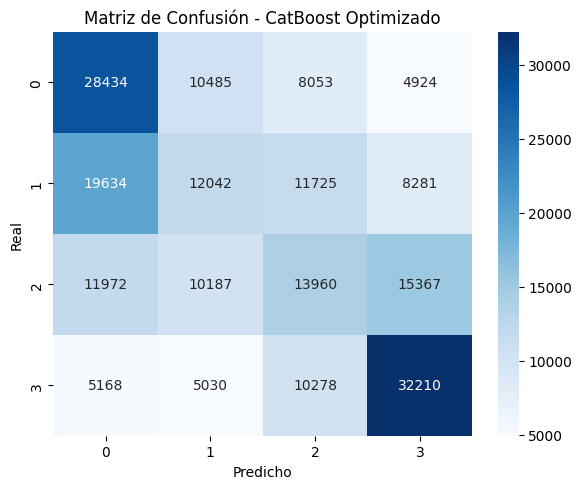

ValueError: Data must be 1-dimensional, got ndarray of shape (296786, 1) instead

In [8]:
# =============================================
# 1. Librerías
# =============================================
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# =============================================
# 2. Cargar datos
# =============================================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# =============================================
# 3. Columnas seleccionadas
# =============================================
cols = [
    'ESTU_VALORMATRICULAUNIVERSIDAD',
    'FAMI_ESTRATOVIVIENDA',
    'FAMI_TIENEINTERNET',
    'FAMI_EDUCACIONPADRE',
    'FAMI_EDUCACIONMADRE',
    'ESTU_HORASSEMANATRABAJA',
    'ESTU_PAGOMATRICULAPROPIO',
    'ESTU_PRGM_DEPARTAMENTO',
    'ESTU_PRGM_ACADEMICO'
]

train = train[['ID'] + cols + ['RENDIMIENTO_GLOBAL']]
test = test[['ID'] + cols]

# =============================================
# 4. Limpieza de valores raros
# =============================================
valores_raros = ['98', '99', '999', 98, 99, 999]
for col in cols:
    train[col] = train[col].replace(valores_raros, np.nan)
    test[col] = test[col].replace(valores_raros, np.nan)

# =============================================
# 5. Imputación mejorada
# =============================================
condicionales = [
    'FAMI_ESTRATOVIVIENDA',
    'FAMI_TIENEINTERNET',
    'FAMI_EDUCACIONPADRE',
    'FAMI_EDUCACIONMADRE'
]

for col in condicionales:
    train[col] = train.groupby('ESTU_PRGM_ACADEMICO')[col].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Desconocido')
    )
    test[col] = test.groupby('ESTU_PRGM_ACADEMICO')[col].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Desconocido')
    )

for col in cols:
    if train[col].isnull().sum() > 0:
        moda = train[col].mode()[0]
        train[col] = train[col].fillna(moda)
    if test[col].isnull().sum() > 0:
        moda = test[col].mode()[0]
        test[col] = test[col].fillna(moda)

# =============================================
# 6. One-hot encoding
# =============================================
def one_hot(df, col):
    dummies = pd.get_dummies(df[col], prefix=col)
    return pd.concat([df.drop(columns=[col]), dummies], axis=1)

for col in cols:
    train = one_hot(train, col)
    test = one_hot(test, col)

test = test.reindex(columns=train.drop(columns=['RENDIMIENTO_GLOBAL']).columns, fill_value=0)

# =============================================
# 7. Variable objetivo
# =============================================
mapa = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
inv_mapa = {v: k for k, v in mapa.items()}
y = train['RENDIMIENTO_GLOBAL'].map(mapa)
X = train.drop(columns=['RENDIMIENTO_GLOBAL'])

# =============================================
# 8. Eliminar columnas con baja frecuencia (<10)
# =============================================
col_sums = X.sum()
columnas_validas = col_sums[col_sums >= 10].index
X = X[columnas_validas]
test = test[columnas_validas]

# =============================================
# 9. Selección de 100 mejores variables
# =============================================
selector = SelectKBest(score_func=f_classif, k=100)
X_sel = selector.fit_transform(X, y)
test_sel = selector.transform(test)

# =============================================
# 10. División estratificada
# =============================================
Xtrain, Xval, ytrain, yval = train_test_split(X_sel, y, test_size=0.3, stratify=y, random_state=42)

# =============================================
# 11. Optimización de CatBoost con RandomizedSearchCV
# =============================================
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'iterations': [200, 500, 800],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0.1, 0.3, 0.5, 1.0]
}

cat = CatBoostClassifier(verbose=0, random_state=42)

search = RandomizedSearchCV(
    cat,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)
search.fit(Xtrain, ytrain)
best_cat = search.best_estimator_

# =============================================
# 12. Evaluación
# =============================================
yval_pred = best_cat.predict(Xval)

print(f"✅ Accuracy CatBoost optimizado: {accuracy_score(yval, yval_pred):.4f}")
print(f"✅ F1 score (macro): {f1_score(yval, yval_pred, average='macro'):.4f}")
print("\n📄 Classification report:\n", classification_report(yval, yval_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(yval, yval_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - CatBoost Optimizado")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# =============================================
# 13. Predicción final y exportación
# =============================================
best_cat.fit(X_sel, y)
y_pred = best_cat.predict(test_sel)

submission = pd.DataFrame({
    'ID': test.index,
    'RENDIMIENTO_GLOBAL': pd.Series(y_pred).map(inv_mapa)
})
submission.to_csv("submission.csv", index=False)
print("📦 Archivo 'submission.csv' guardado.")